In [ ]:
!pip install tensorflow

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
#from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import pandas_ta as ta
import requests

%matplotlib inline

plt.style.use('fivethirtyeight')

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

2022-05-19 21:34:51.688102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 21:34:51.688124: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
!pip install pandas-ta

In [59]:
365*3

1095

In [60]:
# Data comes from:

hnt_csv_path = "https://query1.finance.yahoo.com/v7/finance/download/HNT-USD?period1=1495065600&period2=1652832000&interval=1d&events=history&includeAdjustedClose=true"
btc_csv_path = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1495065600&period2=1652832000&interval=1d&events=history&includeAdjustedClose=true"
dji_csv_path = "https://query1.finance.yahoo.com/v7/finance/download/%5EDJI?period1=1495065600&period2=1652832000&interval=1d&events=history&includeAdjustedClose=true"

sentiment_path = " https://api.alternative.me/fng/?format=json&limit=1095&date_format=us"

# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [61]:
req = requests.get(sentiment_path)

df_sentiment = pd.DataFrame(req.json()['data'])

df_sentiment['Date'] = pd.to_datetime(df_sentiment['timestamp'])

In [62]:
df_sentiment = df_sentiment[["value", "Date"]]

In [63]:
df_sentiment.shape

(1095, 2)

In [64]:
df_hnt = pd.read_csv(hnt_csv_path, parse_dates=['Date'])
df_btc = pd.read_csv(btc_csv_path, parse_dates=['Date'])

In [65]:
df_dji = pd.read_csv(dji_csv_path, parse_dates=['Date'])

In [66]:
df_hnt = df_hnt.sort_values('Date')
df_btc = df_btc.sort_values('Date')
df_dji = df_dji.sort_values('Date')
df_sentiment = df_sentiment.sort_values('Date')

In [67]:
df1 = pd.merge(df_btc, df_dji, 'inner', 'Date')
df2 = pd.merge(df1, df_sentiment, 'inner', 'Date')
df  = pd.merge(df2, df_hnt, 'inner', 'Date')

In [69]:
df.head()

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,value,Open,High,Low,Close,Adj Close,Volume
0,2020-06-08,9760.063477,9782.306641,9675.885742,9771.489258,9771.489258,21486346312,27232.929688,27580.210938,27232.480469,27572.439453,27572.439453,430200000,53,0.273462,0.279798,0.270841,0.277823,0.277823,83279
1,2020-06-09,9774.360352,9836.369141,9664.719727,9795.700195,9795.700195,23717842783,27447.369141,27447.369141,27151.060547,27272.300781,27272.300781,381430000,52,0.272190,0.283733,0.254260,0.272145,0.272145,66395
2,2020-06-10,9794.119141,9908.896484,9728.291016,9870.094727,9870.094727,25706567601,27251.890625,27355.220703,26938.050781,26989.990234,26989.990234,448930000,54,0.272866,0.315967,0.253391,0.276225,0.276225,82810
3,2020-06-11,9870.078125,9938.297852,9263.069336,9321.781250,9321.781250,30247143440,26282.509766,26294.080078,25082.720703,25128.169922,25128.169922,647780000,52,0.276145,0.351870,0.275626,0.291165,0.291165,87567
4,2020-06-12,9320.690430,9540.465820,9285.851563,9480.843750,9480.843750,22610564515,25659.419922,25965.550781,25078.410156,25605.539063,25605.539063,514440000,38,0.285552,0.331206,0.285237,0.328463,0.328463,92564


In [27]:
df.shape

(250, 20)

Text(0, 0.5, 'Close Price (USD)')

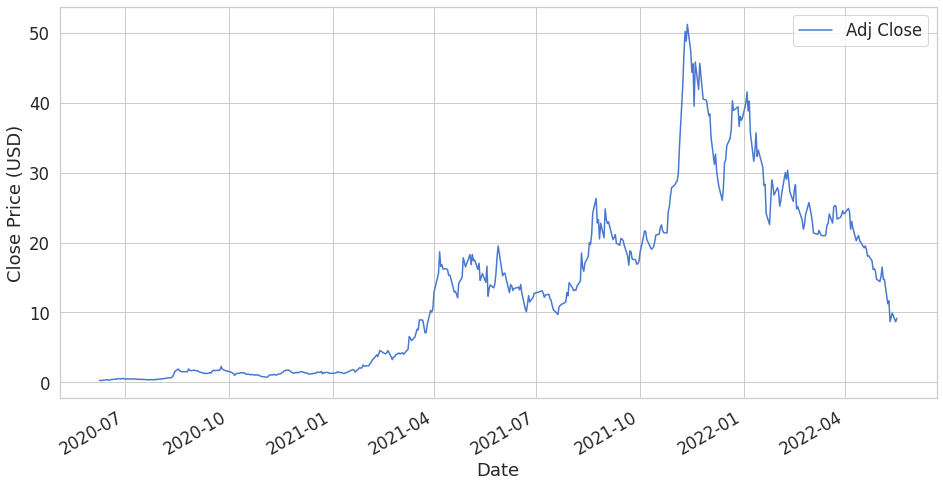

In [70]:
ax = df.plot(x='Date', y='Adj Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Rolling Average

In [71]:
df['RollingClose'] = df['Adj Close'].rolling(7).mean()

In [72]:
df.head()

,Date,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,...,Adj Close_y,Volume_y,value,Open,High,Low,Close,Adj Close,Volume,RollingClose
0,2020-06-08,9760.063477,9782.306641,9675.885742,9771.489258,9771.489258,21486346312,27232.929688,27580.210938,27232.480469,...,27572.439453,430200000,53,0.273462,0.279798,0.270841,0.277823,0.277823,83279,NaN
1,2020-06-09,9774.360352,9836.369141,9664.719727,9795.700195,9795.700195,23717842783,27447.369141,27447.369141,27151.060547,...,27272.300781,381430000,52,0.272190,0.283733,0.254260,0.272145,0.272145,66395,NaN
2,2020-06-10,9794.119141,9908.896484,9728.291016,9870.094727,9870.094727,25706567601,27251.890625,27355.220703,26938.050781,...,26989.990234,448930000,54,0.272866,0.315967,0.253391,0.276225,0.276225,82810,NaN
3,2020-06-11,9870.078125,9938.297852,9263.069336,9321.781250,9321.781250,30247143440,26282.509766,26294.080078,25082.720703,...,25128.169922,647780000,52,0.276145,0.351870,0.275626,0.291165,0.291165,87567,NaN
4,2020-06-12,9320.690430,9540.465820,9285.851563,9480.843750,9480.843750,22610564515,25659.419922,25965.550781,25078.410156,...,25605.539063,514440000,38,0.285552,0.331206,0.285237,0.328463,0.328463,92564,NaN


# Scaler

In [73]:
scaler = MinMaxScaler()

# Normalization

In [ ]:
close_price = df.Close.values.reshape(-1, 1)


# Normalization of Rolling Average

In [74]:
close_price = df.RollingClose.values.reshape(-1, 1)

In [75]:
scaled_close = scaler.fit_transform(close_price)

In [76]:
scaled_close.shape

(491, 1)

In [77]:
np.isnan(scaled_close).any()

True

In [78]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [79]:
scaled_close = scaled_close.reshape(-1, 1)

In [80]:
np.isnan(scaled_close).any()

False

In [81]:
scaled_close.shape

(485, 1)

# Preprocessing

In [82]:
SEQ_LEN = 128

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.7)

In [83]:
X_train.shape

(249, 127, 1)

In [84]:
X_test.shape

(108, 127, 1)

# Model

In [85]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [86]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [87]:
X_train.shape

(249, 127, 1)

In [88]:
y_train.shape

(249, 1)

In [89]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
4/4 [==============================] - 13s 2s/step - loss: 0.0139 - val_loss: 0.1659
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 0.0145 - val_loss: 0.0646
Epoch 3/50
4/4 [==============================] - 4s 1s/step - loss: 0.0097 - val_loss: 0.0764
Epoch 4/50
4/4 [==============================] - 5s 1s/step - loss: 0.0166 - val_loss: 0.1655
Epoch 5/50
4/4 [==============================] - 5s 1s/step - loss: 0.0042 - val_loss: 0.0317
Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 0.0063 - val_loss: 0.0412
Epoch 7/50
4/4 [==============================] - 6s 1s/step - loss: 0.0052 - val_loss: 0.0947
Epoch 8/50
4/4 [==============================] - 6s 1s/step - loss: 0.0027 - val_loss: 0.0325
Epoch 9/50
4/4 [==============================] - 5s 1s/step - loss: 0.0029 - val_loss: 0.0237
Epoch 10/50
4/4 [==============================] - 6s 2s/step - loss: 0.0015 - val_loss: 0.0524
Epoch 11/50
4/4 [==============================]

In [90]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 181ms/step - loss: 0.0039


0.0038791527040302753

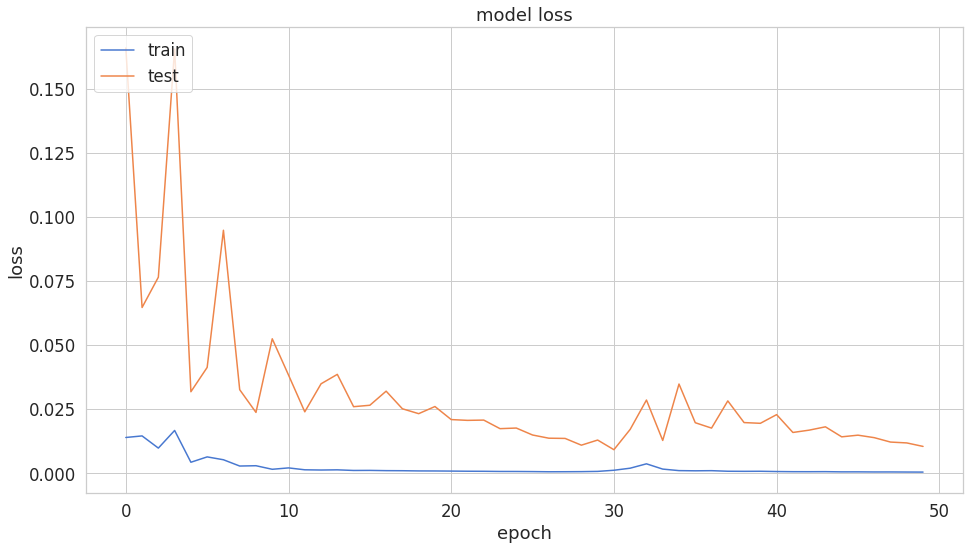

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

4/4 [==============================] - 2s 169ms/step


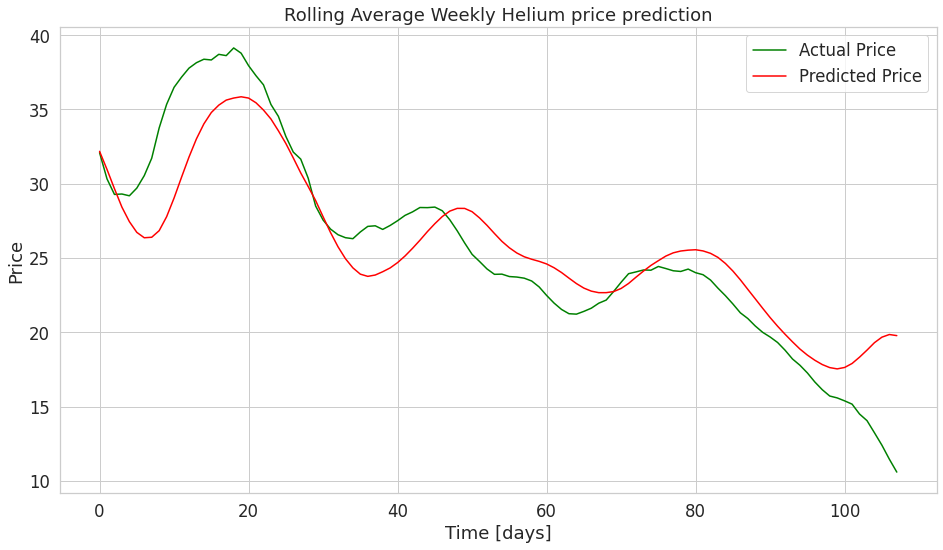

In [92]:
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Rolling Average Weekly Helium price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Make Bands

In [96]:
yhi_df = pd.DataFrame(y_hat_inverse)
yti_df = pd.DataFrame(y_test_inverse)
yhi_df.columns = ['Predicted Price']
yti_df.columns = ['Predicted Price']

In [117]:
LITTLE_STEP = 3
BIG_STEP    = 7

yhi_df = pd.DataFrame(y_hat_inverse)
yhi_df.columns = ['Predicted Price']

little_key = "SMA {}".format(LITTLE_STEP)
big_key    = "SMA {}".format(BIG_STEP)


# calculate the standar deviation
yhi_df['STD {}'.format(LITTLE_STEP)] = yhi_df['Predicted Price'].rolling(window=LITTLE_STEP).std()
yhi_df['STD {}'.format(BIG_STEP)]= yhi_df['Predicted Price'].rolling(window=BIG_STEP).std()

yhi_df['SMA {}'.format(LITTLE_STEP)] = ta.sma(yhi_df['Predicted Price'], LITTLE_STEP)
yhi_df['SMA {}'.format(BIG_STEP)]= ta.sma(yhi_df['Predicted Price'], BIG_STEP)

yhi_df['Upper SMA {}'.format(LITTLE_STEP)] = yhi_df['SMA {}'.format(LITTLE_STEP)] + 2 * yhi_df['STD {}'.format(LITTLE_STEP)]
yhi_df['Lower SMA {}'.format(LITTLE_STEP)] = yhi_df['SMA {}'.format(LITTLE_STEP)] - 2 * yhi_df['STD {}'.format(LITTLE_STEP)]

yhi_df['Upper SMA {}'.format(BIG_STEP)] = yhi_df['SMA {}'.format(BIG_STEP)] + 2 * yhi_df['STD {}'.format(LITTLE_STEP)]
yhi_df['Lower SMA {}'.format(BIG_STEP)] = yhi_df['SMA {}'.format(BIG_STEP)] - 2 * yhi_df['STD {}'.format(BIG_STEP)]


In [118]:
yhi_df

,Predicted Price,STD 3,STD 7,SMA 3,SMA 7,Upper SMA 3,Lower SMA 3,Upper SMA 7,Lower SMA 7
0,32.176369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30.957729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29.661713,1.257526,NaN,30.931937,NaN,33.446990,28.416884,NaN,NaN
3,28.423130,1.267408,NaN,29.680857,NaN,32.215674,27.146041,NaN,NaN
4,27.449091,1.108943,NaN,28.511311,NaN,30.729198,26.293424,NaN,NaN
...,...,...,...,...,...,...,...,...,...
103,18.804276,0.449264,0.457795,18.347252,17.954843,19.245780,17.448724,18.853371,17.039254
104,19.305286,0.487056,0.677833,18.813623,18.165149,19.787736,17.839511,19.139262,16.809484
105,19.675570,0.437278,0.831928,19.261710,18.457489,20.136267,18.387154,19.332046,16.793634
106,19.854406,0.280067,0.866195,19.611754,18.787846,20.171888,19.051620,19.347979,17.055455


In [119]:
#SMA BUY SELL
#Function for buy and sell signal
def buy_sell(d):
    signalBuy = []
    signalSell = []
    position = False
    
    little_key = "SMA {}".format(LITTLE_STEP)
    big_key    = "SMA {}".format(BIG_STEP)
    
    for i in range(len(d)):
        
        if (d[little_key][i]) > d[big_key][i]:
            if position == False :
                signalBuy.append(d['Predicted Price'][i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif (d[little_key][i]) < d[big_key][i]:
            if position == True:
                signalBuy.append(np.nan)
                signalSell.append(d['Predicted Price'][i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
                                
    return pd.Series([signalBuy, signalSell])


In [120]:
yhi_df['Buy_Signal_price'], yhi_df['Sell_Signal_price'] = buy_sell(yhi_df)

In [121]:
yhi_df

,Predicted Price,STD 3,STD 7,SMA 3,SMA 7,Upper SMA 3,Lower SMA 3,Upper SMA 7,Lower SMA 7,Buy_Signal_price,Sell_Signal_price
0,32.176369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30.957729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29.661713,1.257526,NaN,30.931937,NaN,33.446990,28.416884,NaN,NaN,NaN,NaN
3,28.423130,1.267408,NaN,29.680857,NaN,32.215674,27.146041,NaN,NaN,NaN,NaN
4,27.449091,1.108943,NaN,28.511311,NaN,30.729198,26.293424,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
103,18.804276,0.449264,0.457795,18.347252,17.954843,19.245780,17.448724,18.853371,17.039254,NaN,NaN
104,19.305286,0.487056,0.677833,18.813623,18.165149,19.787736,17.839511,19.139262,16.809484,NaN,NaN
105,19.675570,0.437278,0.831928,19.261710,18.457489,20.136267,18.387154,19.332046,16.793634,NaN,NaN
106,19.854406,0.280067,0.866195,19.611754,18.787846,20.171888,19.051620,19.347979,17.055455,NaN,NaN


In [122]:
np.isnan(yhi_df).all()

Predicted Price      False
STD 3                False
STD 7                False
SMA 3                False
SMA 7                False
Upper SMA 3          False
Lower SMA 3          False
Upper SMA 7          False
Lower SMA 7          False
Buy_Signal_price     False
Sell_Signal_price    False
dtype: bool

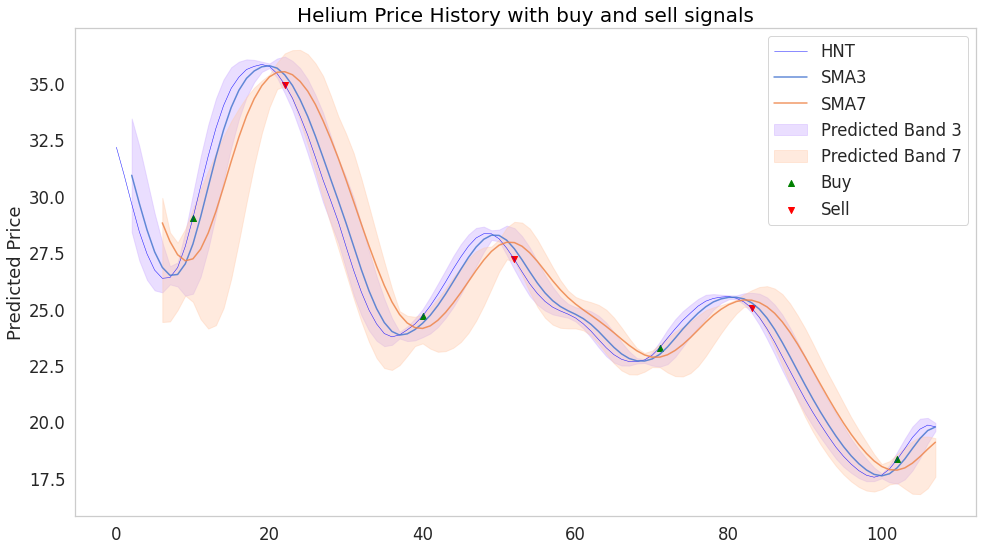

In [123]:


fig, ax = plt.subplots(figsize=(14,8))
ax.plot(yhi_df['Predicted Price'] , label = "HNT" ,linewidth=0.5, color='blue', alpha = 0.9)
ax.plot(yhi_df['SMA {}'.format(LITTLE_STEP)], label = 'SMA{}'.format(LITTLE_STEP), alpha = 0.85)
ax.plot(yhi_df['SMA {}'.format(BIG_STEP)], label = 'SMA{}'.format(BIG_STEP) , alpha = 0.85)

ax.fill_between(yhi_df.index, yhi_df['Lower SMA {}'.format(LITTLE_STEP)], yhi_df['Upper SMA {}'.format(LITTLE_STEP)], color='#CCADFF', alpha=0.4, label="Predicted Band {}".format(LITTLE_STEP))
ax.fill_between(yhi_df.index, yhi_df['Lower SMA {}'.format(BIG_STEP)], yhi_df['Upper SMA {}'.format(BIG_STEP)], color='#FFCCAD', alpha=0.4, label="Predicted Band {}".format(BIG_STEP))

ax.scatter(yhi_df.index , yhi_df['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
ax.scatter(yhi_df.index , yhi_df['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
ax.set_title("Helium Price History with buy and sell signals",fontsize=20, color='black')
#ax.set_xlabel(f'{startdate} - {end_date}' ,fontsize=18)
ax.set_ylabel('Predicted Price' , fontsize=18)
legend = ax.legend()
ax.grid()
plt.tight_layout()
plt.show()